In [1]:
from fastai import *
from fastai.vision import *
from fastai.utils.ipython import *
from fastai.callbacks.tracker import SaveModelCallback
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from functools import partial

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
path = Path(".")
data_path = path / ".." / ".." / ".." / "Dataset" / "Herlev Dataset"
data_path.ls()

[PosixPath('../../../Dataset/Herlev Dataset/best-vgg19-herlev-multiclass-5fold.pkl'),
 PosixPath('../../../Dataset/Herlev Dataset/best-effb3-herlev-multiclass.pkl'),
 PosixPath('../../../Dataset/Herlev Dataset/abnormal_moderate-dysplastic'),
 PosixPath('../../../Dataset/Herlev Dataset/normal_superficiel'),
 PosixPath('../../../Dataset/Herlev Dataset/abnormal_light-dysplastic'),
 PosixPath('../../../Dataset/Herlev Dataset/abnormal_severe-dysplastic'),
 PosixPath('../../../Dataset/Herlev Dataset/normal_columnar'),
 PosixPath('../../../Dataset/Herlev Dataset/normal_intermediate'),
 PosixPath('../../../Dataset/Herlev Dataset/abnormal_carcinoma-in-situ'),
 PosixPath('../../../Dataset/Herlev Dataset/models')]

In [4]:
data_init = (ImageList.from_folder(data_path)
            .split_none()
            .label_from_folder())
data_init

LabelLists;

Train: LabelList (917 items)
x: ImageList
Image (3, 83, 146),Image (3, 106, 116),Image (3, 129, 119),Image (3, 108, 110),Image (3, 209, 173)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../../../Dataset/Herlev Dataset;

Test: None

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf

StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [6]:
tfms = get_transforms(flip_vert=True, max_warp=0.0, max_rotate=30.0)

In [7]:
idxs = [[train_idx, val_idx] for train_idx, val_idx in skf.split(data_init.x.items, data_init.y.items)]

In [8]:
def model_callback(model, model_name):
    return [SaveModelCallback(model, every="improvement", monitor="accuracy", name=model_name)]

In [11]:
our_metrics = [accuracy, Precision(average="macro"), Recall(average="macro"), FBeta(average="macro"), KappaScore(weights="quadratic")]
our_metrics

[<function fastai.metrics.accuracy(input:torch.Tensor, targs:torch.Tensor) -> <function NewType.<locals>.new_type at 0x7f71ac64e378>>,
 Precision(average='macro', pos_label=1, eps=1e-09),
 Recall(average='macro', pos_label=1, eps=1e-09),
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=2),
 KappaScore(weights='quadratic')]

# Fold-1

In [9]:
fold_idxs = idxs[0]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (733 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (184 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

In [12]:
learner = cnn_learner(fold_data, models.resnet34, metrics=our_metrics).to_fp16()
learner

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/fadege/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Learner(data=ImageDataBunch;

Train: LabelList (733 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (184 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


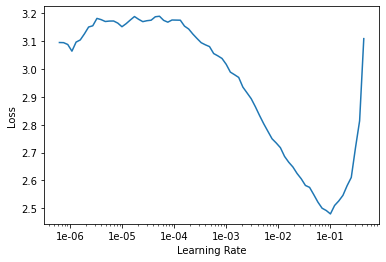

In [13]:
learner.lr_find()
learner.recorder.plot()

In [14]:
learner.fit_one_cycle(40, max_lr=slice(1e-02), callbacks=model_callback(learner, "best-rn34-herlev-multiclass-fold1-stage1"))
learner.save("last-rn34-herlev-multiclass-fold1-stage1")

Better model found at epoch 0 with accuracy value: 0.34239131212234497.
Better model found at epoch 1 with accuracy value: 0.45652174949645996.
Better model found at epoch 2 with accuracy value: 0.510869562625885.
Better model found at epoch 3 with accuracy value: 0.5271739363670349.
Better model found at epoch 11 with accuracy value: 0.532608687877655.
Better model found at epoch 14 with accuracy value: 0.5652173757553101.
Better model found at epoch 24 with accuracy value: 0.5869565010070801.
Better model found at epoch 30 with accuracy value: 0.614130437374115.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


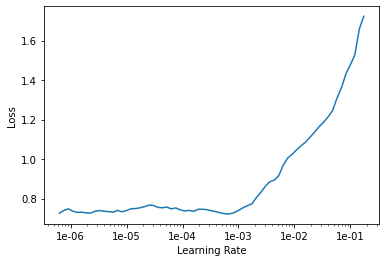

In [15]:
learner.load("best-rn34-herlev-multiclass-fold1-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [16]:
learner.fit_one_cycle(40, max_lr=slice(1e-04, 1e-03), callbacks=model_callback(learner, "best-rn34-herlev-multiclass-fold1-stage2"))
learner.save("last-rn34-herlev-multiclass-fold1-stage2")

Better model found at epoch 0 with accuracy value: 0.58152174949646.
Better model found at epoch 4 with accuracy value: 0.592391312122345.
Better model found at epoch 5 with accuracy value: 0.6086956262588501.
Better model found at epoch 6 with accuracy value: 0.6195651888847351.
Better model found at epoch 7 with accuracy value: 0.625.
Better model found at epoch 12 with accuracy value: 0.657608687877655.


# Fold-2

In [17]:
fold_idxs = idxs[1]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (733 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (184 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


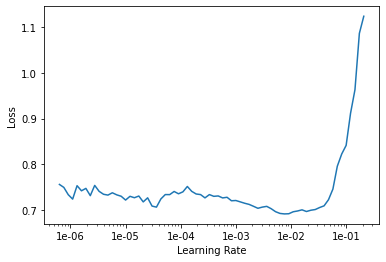

In [18]:
learner.load("best-rn34-herlev-multiclass-fold1-stage2")
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [19]:
learner.fit_one_cycle(40, max_lr=slice(3.5e-03), callbacks=model_callback(learner, "best-rn34-herlev-multiclass-fold2-stage1"))
learner.save("last-rn34-herlev-multiclass-fold2-stage1")

Better model found at epoch 0 with accuracy value: 0.8586956262588501.
Better model found at epoch 1 with accuracy value: 0.864130437374115.
Better model found at epoch 2 with accuracy value: 0.875.
Better model found at epoch 3 with accuracy value: 0.885869562625885.
Better model found at epoch 4 with accuracy value: 0.9021739363670349.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


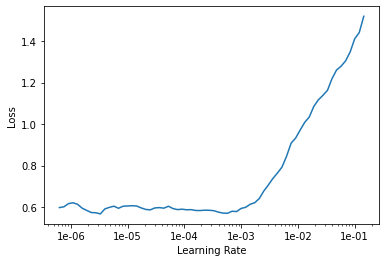

In [20]:
learner.load("best-rn34-herlev-multiclass-fold2-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [21]:
learner.fit_one_cycle(40, max_lr=slice(1.4e-06, 3.5e-04), callbacks=model_callback(learner, "best-rn34-herlev-multiclass-fold2-stage2"))
learner.save("last-rn34-herlev-multiclass-fold2-stage2")

Better model found at epoch 0 with accuracy value: 0.89673912525177.
Better model found at epoch 1 with accuracy value: 0.907608687877655.
Better model found at epoch 7 with accuracy value: 0.9130434989929199.
Better model found at epoch 10 with accuracy value: 0.91847825050354.
Better model found at epoch 17 with accuracy value: 0.9239130616188049.
Better model found at epoch 27 with accuracy value: 0.9347826242446899.


# Fold-3

In [22]:
fold_idxs = idxs[2]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (734 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (183 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


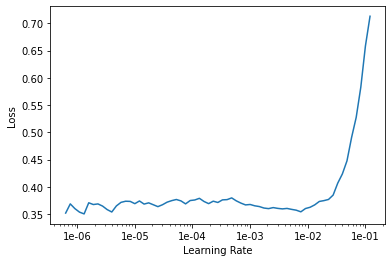

In [23]:
learner.load("best-rn34-herlev-multiclass-fold2-stage2")
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [24]:
learner.fit_one_cycle(40, max_lr=slice(1e-03), callbacks=model_callback(learner, "best-rn34-herlev-multiclass-fold3-stage1"))
learner.save("last-rn34-herlev-multiclass-fold3-stage1")

Better model found at epoch 0 with accuracy value: 0.9836065769195557.
Better model found at epoch 5 with accuracy value: 0.9890710115432739.
Better model found at epoch 14 with accuracy value: 0.994535505771637.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


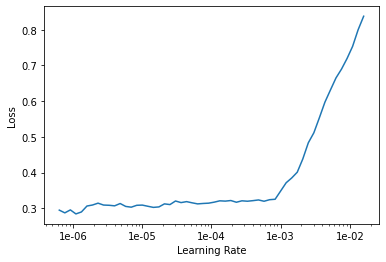

In [25]:
learner.load("best-rn34-herlev-multiclass-fold3-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [26]:
learner.fit_one_cycle(40, max_lr=slice(1e-04), callbacks=model_callback(learner, "best-rn34-herlev-multiclass-fold3-stage2"))
learner.save("last-rn34-herlev-multiclass-fold3-stage2")

Better model found at epoch 0 with accuracy value: 0.9890710115432739.
Better model found at epoch 2 with accuracy value: 0.994535505771637.


# Fold-4

In [27]:
fold_idxs = idxs[3]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (734 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (183 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


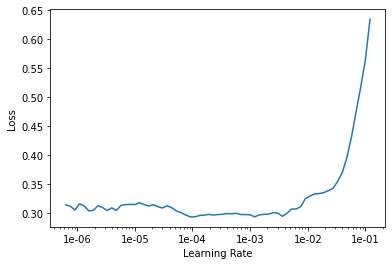

In [28]:
learner.load("best-rn34-herlev-multiclass-fold3-stage2")
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [29]:
learner.fit_one_cycle(40, max_lr=slice(4e-05), callbacks=model_callback(learner, "best-rn34-herlev-multiclass-fold4-stage1"))
learner.save("last-rn34-herlev-multiclass-fold4-stage1")

Better model found at epoch 0 with accuracy value: 0.9726775884628296.
Better model found at epoch 7 with accuracy value: 0.9781420826911926.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


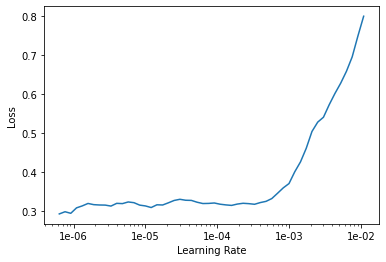

In [30]:
learner.load("best-rn34-herlev-multiclass-fold4-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [31]:
learner.fit_one_cycle(40, max_lr=slice(4e-07), callbacks=model_callback(learner, "best-rn34-herlev-multiclass-fold4-stage2"))
learner.save("last-rn34-herlev-multiclass-fold4-stage2")

Better model found at epoch 0 with accuracy value: 0.9672130942344666.
Better model found at epoch 1 with accuracy value: 0.9726775884628296.
Better model found at epoch 21 with accuracy value: 0.9781420826911926.


# Fold-5

In [32]:
fold_idxs = idxs[4]
fold_data = (ImageList.from_folder(data_path)
            .split_by_idxs(fold_idxs[0], fold_idxs[1])
            .label_from_folder()
            .transform(tfms, size=64)
            .databunch(bs=64)
            .normalize(imagenet_stats))
fold_data

ImageDataBunch;

Train: LabelList (734 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Valid: LabelList (183 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic,abnormal_moderate-dysplastic
Path: ../../../Dataset/Herlev Dataset;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


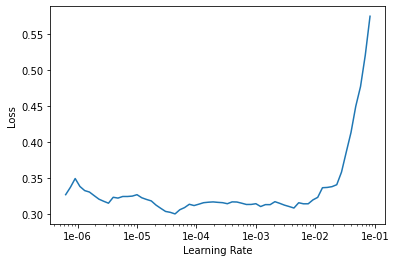

In [33]:
learner.load("best-rn34-herlev-multiclass-fold4-stage2")
learner.data = fold_data
learner.freeze()
learner = to_fp16(learner)
learner.lr_find()
learner.recorder.plot()

In [34]:
learner.fit_one_cycle(40, max_lr=slice(2e-05), callbacks=model_callback(learner, "best-rn34-herlev-multiclass-fold5-stage1"))
learner.save("last-rn34-herlev-multiclass-fold5-stage1")

Better model found at epoch 0 with accuracy value: 0.9781420826911926.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


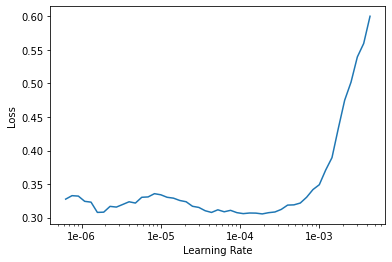

In [35]:
learner.load("best-rn34-herlev-multiclass-fold5-stage1")
learner = to_fp16(learner)
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [36]:
learner.fit_one_cycle(40, max_lr=slice(1e-06), callbacks=model_callback(learner, "best-rn34-herlev-multiclass-fold5-stage2"))
learner.save("last-rn34-herlev-multiclass-fold5-stage2")

Better model found at epoch 0 with accuracy value: 0.9781420826911926.


In [37]:
learner.load("best-rn34-herlev-multiclass-fold5-stage2")
learner.export("best-rn34-herlev-multiclass-5fold.pkl")